## Objectif de notre ML: 
Notre objectif est de prédire un métier ou code_rome (target_y) à partir de compétences prédéfinies (variable_X).

Métriques d'évaluation:
Score F1 : combine précision et rappel pour donner une vue d'ensemble de la performance du modèle (Multilabel-classification).


# Pre-processing
Préparation de la data: Les mettre dans un format propice au ML.
1. Élimination des NaN (dropna(), imputation, colonnes vides).
2. Encodage des variables catégoriques.
3. Suppression des valeurs aberrantes nuisibles au modèle.
4. Sélection des fonctionnalités (sélection des variables pertinentes).
5. Ingénierie de fonctionnalités (création de nouvelles variables).
6. Mise à l'échelle des fonctionnalités (normalisation ou standardisation des données).
7. Création du train set/test set.
---

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import io
import os
import boto3
from dotenv import load_dotenv
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import f1_score, confusion_matrix, classification_report

In [2]:
# Modification des paramèters d'affichage de Pandas:
pd.set_option('display.max_row', 111)
pd.set_option('display.max_column', 111)
pd.set_option("display.max_colwidth", None)

In [3]:
# Load environment variables with specific location depend on EDI (PyCharm/VSCode)
if not load_dotenv('../settings/.env'):
    print("Load env from alternative from path")
    load_dotenv('script/settings/.env')

# Check settings (for debug session only)
if __debug__:
    print('Debug ON')
    print("Environment data:", 
        "\nS3_ENDPOINT_URL:", os.getenv("S3_ENDPOINT_URL"),
        "\nS3_ACCESS_KEY_ID (len):", len(os.getenv("S3_ACCESS_KEY_ID")), "bytes",
        "\nS3_SECRET_ACCESS_KEY (len):", len(os.getenv("S3_SECRET_ACCESS_KEY")), "bytes",
        "\nS3_REGION:", os.getenv("S3_REGION")
        )

Debug ON
Environment data: 
S3_ENDPOINT_URL: https://bhckzdwrhhfaxbidmwpm.supabase.co/storage/v1/s3 
S3_ACCESS_KEY_ID (len): 32 bytes 
S3_SECRET_ACCESS_KEY (len): 64 bytes 
S3_REGION: eu-west-3


In [4]:
# Init S3 client 
try:
    s3_client = boto3.client(
        service_name='s3',
        region_name=os.getenv("S3_REGION"),
        endpoint_url=os.getenv("S3_ENDPOINT_URL"),
        aws_access_key_id=os.getenv("S3_ACCESS_KEY_ID"), 
        aws_secret_access_key=os.getenv("S3_SECRET_ACCESS_KEY")
    ) 
except Exception as ex:
    print(ex)

# Define function to read ROME CSV files
def read_ml_from_s3(s3_file_key):
    bucket_name = 'ML'
    s3_ml_path = ''

    try:
        obj = s3_client.get_object(Bucket= bucket_name, Key= s3_ml_path + s3_file_key)
        df = pd.read_csv(io.BytesIO(obj['Body'].read()))
        return df
    except Exception as ex:
        print("Erreur de lecture du fichier depuis le buecket S3:")
        print("->", ex)
    
    return None

# S3 CSV reading test
df = read_ml_from_s3( 'df_competence_rome_eda_v2.csv')
if df is not None:
    print("Lecture du fichier réussi:")
    print(f"-> CSV: Nb de lignes: {df.shape[0]}, Nb de colonnes: {df.shape[1]}")

Lecture du fichier réussi:
-> CSV: Nb de lignes: 38961, Nb de colonnes: 17


In [41]:
# On récupère les données qui nous seront utiles
file_path_name = 'df_competence_rome_eda_v2.csv'

try:
    df = read_ml_from_s3( file_path_name)
    print(f"Arborescence: Nb de lignes: {df.shape[0]}, Nb de colonnes: {df.shape[1]}")
except:
    print('Erreur lors de la lecture du fichier!')

Arborescence: Nb de lignes: 38961, Nb de colonnes: 17


---
### Affichage des données brutes

In [42]:
df.shape

(38961, 17)

In [43]:
df.head(20)

,Unnamed: 0,code_rome,libelle_rome,emploi_cadre,code_ogr_competence,libelle_competence,cat_comp,sous_cat_comp,enjeu,objectif,libelle_macro_competence,domaine_competence,coeur_metier,transition_eco_x,transition_num_x,transition_eco_y,transition_num_y
0,0,A1101,Conducteur / Conductrice d'engins agricoles,NaN,104016,Contrôler le fonctionnement d'un dispositif de sécurité,Savoir-faire,Technique expert,Prévention des risques,Contrôler la production,"Contrôler le fonctionnement d'un équipement, d'une machine, d'une installation","Production, Construction, Qualité, Logistique",NaN,Emploi Blanc,NaN,NaN,N
1,1,A1101,Conducteur / Conductrice d'engins agricoles,NaN,107141,Entretenir les mécanismes d'un engin motorisé,Savoir-faire,Technique,"Maintenance, Réparation","Entretenir, corriger","Entretenir un équipement, une machine, une installation","Production, Construction, Qualité, Logistique",NaN,Emploi Blanc,NaN,NaN,N
2,2,A1101,Conducteur / Conductrice d'engins agricoles,NaN,110024,Conduire un poids lourd,Savoir-faire,Technique,Transport,Assurer un transport,Conduire un véhicule routier,"Production, Construction, Qualité, Logistique",NaN,Emploi Blanc,NaN,NaN,N
3,3,A1101,Conducteur / Conductrice d'engins agricoles,NaN,117548,Stocker un produit,Savoir-faire,Technique,Gestion des stocks,"Manutentionner, conditionner des produits","Trier, ranger des produits, des matières premières","Production, Construction, Qualité, Logistique",NaN,Emploi Blanc,NaN,NaN,N
4,4,A1101,Conducteur / Conductrice d'engins agricoles,NaN,122567,Débroussailler une plantation et ses chemins d'accès,Savoir-faire,Technique,Aménagement,Aménager un espace,"Aménager, entretenir un espace naturel, une forêt","Production, Construction, Qualité, Logistique",NaN,Emploi Blanc,NaN,O,N
5,5,A1101,Conducteur / Conductrice d'engins agricoles,NaN,122568,Contrôler l'état d'une plantation,Savoir-faire,Technique,Aménagement,Aménager un espace,"Aménager, entretenir un espace naturel, une forêt","Production, Construction, Qualité, Logistique",NaN,Emploi Blanc,NaN,NaN,N
6,6,A1101,Conducteur / Conductrice d'engins agricoles,NaN,122573,"Planifier une opération de semis, de traitement ou de récolte sur un site d'exploitation",Savoir-faire,Technique expert,Conception,"Concevoir, spécifier","Elaborer et planifier un programme de production, d'exploitation","Production, Construction, Qualité, Logistique",Principale,Emploi Blanc,NaN,NaN,N
7,7,A1101,Conducteur / Conductrice d'engins agricoles,NaN,122730,"Préparer les sols, les plantations (épandage, semis, etc.)",Savoir-faire,Technique,"Production, Fabrication","Cultiver, produire",Cultiver et récolter des végétaux / minéraux,"Production, Construction, Qualité, Logistique",Principale,Emploi Blanc,NaN,NaN,N
8,8,A1101,Conducteur / Conductrice d'engins agricoles,NaN,122817,Réaliser des travaux d'aménagement,Savoir-faire,Technique,Aménagement,Aménager un espace,"Aménager, entretenir un espace naturel, une forêt","Production, Construction, Qualité, Logistique",NaN,Emploi Blanc,NaN,NaN,N
9,9,A1101,Conducteur / Conductrice d'engins agricoles,NaN,122853,Récolter un produit à maturité et selon les consignes de calibrage,Savoir-faire,Technique,"Production, Fabrication","Cultiver, produire",Cultiver et récolter des végétaux / minéraux,"Production, Construction, Qualité, Logistique",Principale,Emploi Blanc,NaN,NaN,N


---
## 1. Élimination des NaN (dropna(), imputation, colonnes vides).

### Suppression des colonnes inutiles

Suite à notre analyse et notre connaissance avancé des données, nous avons décidé de supprimer les colonnes suivantes : 
- Unnamed: 0: Identifiant généré lors de l'exportation en CSV qui nous est inutile.
- libelle_rome: Nous utiliserons le code_rome pour identifier les métiers.
- libelle_competence: Nous utiliserons le code_ogr_competence pour identifier les métiers.
- transition_eco_x: Elle est liée à la colonne des métiers et non pas aux compétences.
- transition_eco_y: Trop de valeurs non définies (+ de 58%)
- transition_num_x: Elle est liée à la colonne des métiers et non pas aux compétences.
- transition_num_y: Trop de valeurs non définie (15%).
- cat_comp: Ne contient qu'une seule valeur pour toutes les lignes du dataset.
- emploi_cadre: Elle est liée à la colonne des métiers et non pas aux compétences.


In [44]:
df = df.drop(columns=['Unnamed: 0', 'libelle_rome', 'libelle_competence', 'transition_eco_x', 'transition_eco_y', 'transition_num_x', 'transition_num_y', 'cat_comp', 'emploi_cadre'])

In [45]:
df.head(10)

,code_rome,code_ogr_competence,sous_cat_comp,enjeu,objectif,libelle_macro_competence,domaine_competence,coeur_metier
0,A1101,104016,Technique expert,Prévention des risques,Contrôler la production,"Contrôler le fonctionnement d'un équipement, d'une machine, d'une installation","Production, Construction, Qualité, Logistique",NaN
1,A1101,107141,Technique,"Maintenance, Réparation","Entretenir, corriger","Entretenir un équipement, une machine, une installation","Production, Construction, Qualité, Logistique",NaN
2,A1101,110024,Technique,Transport,Assurer un transport,Conduire un véhicule routier,"Production, Construction, Qualité, Logistique",NaN
3,A1101,117548,Technique,Gestion des stocks,"Manutentionner, conditionner des produits","Trier, ranger des produits, des matières premières","Production, Construction, Qualité, Logistique",NaN
4,A1101,122567,Technique,Aménagement,Aménager un espace,"Aménager, entretenir un espace naturel, une forêt","Production, Construction, Qualité, Logistique",NaN
5,A1101,122568,Technique,Aménagement,Aménager un espace,"Aménager, entretenir un espace naturel, une forêt","Production, Construction, Qualité, Logistique",NaN
6,A1101,122573,Technique expert,Conception,"Concevoir, spécifier","Elaborer et planifier un programme de production, d'exploitation","Production, Construction, Qualité, Logistique",Principale
7,A1101,122730,Technique,"Production, Fabrication","Cultiver, produire",Cultiver et récolter des végétaux / minéraux,"Production, Construction, Qualité, Logistique",Principale
8,A1101,122817,Technique,Aménagement,Aménager un espace,"Aménager, entretenir un espace naturel, une forêt","Production, Construction, Qualité, Logistique",NaN
9,A1101,122853,Technique,"Production, Fabrication","Cultiver, produire",Cultiver et récolter des végétaux / minéraux,"Production, Construction, Qualité, Logistique",Principale


In [46]:
df_nan = (df.isna().sum()/df.shape[0]).sort_values(ascending= True)
df_nan = df_nan * 100
print(f"{df_nan.round(2)}")

code_rome                    0.00
code_ogr_competence          0.00
sous_cat_comp                0.00
enjeu                        0.00
objectif                     0.00
libelle_macro_competence     0.00
domaine_competence           0.00
coeur_metier                58.83
dtype: float64


In [49]:
# Remplacer les valeur NaN de la colonne coeur_metier
df["coeur_metier"] = df["coeur_metier"].fillna("Secondaire")
df.head(10)

,code_rome,code_ogr_competence,sous_cat_comp,enjeu,objectif,libelle_macro_competence,domaine_competence,coeur_metier
0,A1101,104016,Technique expert,Prévention des risques,Contrôler la production,"Contrôler le fonctionnement d'un équipement, d'une machine, d'une installation","Production, Construction, Qualité, Logistique",Secondaire
1,A1101,107141,Technique,"Maintenance, Réparation","Entretenir, corriger","Entretenir un équipement, une machine, une installation","Production, Construction, Qualité, Logistique",Secondaire
2,A1101,110024,Technique,Transport,Assurer un transport,Conduire un véhicule routier,"Production, Construction, Qualité, Logistique",Secondaire
3,A1101,117548,Technique,Gestion des stocks,"Manutentionner, conditionner des produits","Trier, ranger des produits, des matières premières","Production, Construction, Qualité, Logistique",Secondaire
4,A1101,122567,Technique,Aménagement,Aménager un espace,"Aménager, entretenir un espace naturel, une forêt","Production, Construction, Qualité, Logistique",Secondaire
5,A1101,122568,Technique,Aménagement,Aménager un espace,"Aménager, entretenir un espace naturel, une forêt","Production, Construction, Qualité, Logistique",Secondaire
6,A1101,122573,Technique expert,Conception,"Concevoir, spécifier","Elaborer et planifier un programme de production, d'exploitation","Production, Construction, Qualité, Logistique",Principale
7,A1101,122730,Technique,"Production, Fabrication","Cultiver, produire",Cultiver et récolter des végétaux / minéraux,"Production, Construction, Qualité, Logistique",Principale
8,A1101,122817,Technique,Aménagement,Aménager un espace,"Aménager, entretenir un espace naturel, une forêt","Production, Construction, Qualité, Logistique",Secondaire
9,A1101,122853,Technique,"Production, Fabrication","Cultiver, produire",Cultiver et récolter des végétaux / minéraux,"Production, Construction, Qualité, Logistique",Principale


In [50]:
# Checking
df_nan = (df.isna().sum()/df.shape[0]).sort_values(ascending= True)
df_nan = df_nan * 100
print(f"{df_nan.round(2)}")

code_rome                   0.0
code_ogr_competence         0.0
sous_cat_comp               0.0
enjeu                       0.0
objectif                    0.0
libelle_macro_competence    0.0
domaine_competence          0.0
coeur_metier                0.0
dtype: float64


---
## 2. Encodage des variables catégoriques.

In [58]:
cat_cols = ['coeur_metier', 'sous_cat_comp']
 
#encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False) 
encoder = OrdinalEncoder()
result = encoder.fit_transform(df[cat_cols])

display(pd.DataFrame(result, columns=encoder.get_feature_names_out()))


,coeur_metier,sous_cat_comp
0,1.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
...,...,...
38956,0.0,1.0
38957,0.0,1.0
38958,0.0,0.0
38959,1.0,1.0


---
## 3. Suppression des valeurs aberrantes nuisibles au modèle.

---
## 4. Sélection des fonctionnalités (sélection des variables pertinentes).

---
## 5. Ingénierie de fonctionnalités (création de nouvelles variables).

--- 
## 6. Mise à l'échelle des fonctionnalités (normalisation ou standardisation des données).

---
## 7. Création du train set/test set.

# --- Ancien code = peut être supprimé ---

# Créer les sous-ensembles de données

In [135]:
missing_rate = df.isna().sum()/df.shape[0]

In [137]:
blood_columns = list(df.columns[(missing_rate < 0.9) & (missing_rate >0.88)])
viral_columns = list(df.columns[(missing_rate < 0.80) & (missing_rate > 0.75)])

In [139]:
key_columns = ['Patient age quantile', 'SARS-Cov-2 exam result']

In [141]:
df = df[key_columns + blood_columns + viral_columns]
df.head()

,Patient age quantile,SARS-Cov-2 exam result,Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,CoronavirusNL63,Rhinovirus/Enterovirus,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2
0,13,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,17,negative,0.236515,-0.02234,-0.517413,0.010677,0.102004,0.318366,-0.95079,-0.09461,-0.223767,-0.292269,1.482158,0.166192,0.357547,-0.625073,not_detected,not_detected,not_detected,not_detected,not_detected,detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected
2,8,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,15,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected


# Train set & Test set & Nettoyage & Encodage

### Splittage

In [145]:
from sklearn.model_selection import train_test_split

In [147]:
df = data.copy()
df = df[key_columns + blood_columns + viral_columns]
df.head()

,Patient age quantile,SARS-Cov-2 exam result,Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,CoronavirusNL63,Rhinovirus/Enterovirus,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2
0,13,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,17,negative,0.236515,-0.02234,-0.517413,0.010677,0.102004,0.318366,-0.95079,-0.09461,-0.223767,-0.292269,1.482158,0.166192,0.357547,-0.625073,not_detected,not_detected,not_detected,not_detected,not_detected,detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected
2,8,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,15,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected


In [149]:
trainset, testset = train_test_split(df, test_size= 0.2, random_state= 0)

In [151]:
trainset['SARS-Cov-2 exam result'].value_counts(normalize= True)

SARS-Cov-2 exam result
negative    0.900997
positive    0.099003
Name: proportion, dtype: float64

In [153]:
testset['SARS-Cov-2 exam result'].value_counts(normalize= True)

SARS-Cov-2 exam result
negative    0.901683
positive    0.098317
Name: proportion, dtype: float64

In [155]:
# -> Les valeurs ont le même taux de répartition de valeur: Elles sont bien réparties dans les 2 dataset

### Encodage

In [158]:
def encodage(dataframe):

    code = {'negative': 0,
       'positive': 1,
       'not_detected': 0,
       'detected': 1
       }

    for col in dataframe.select_dtypes('object').columns:
        dataframe[col] = dataframe[col].map(code)
        #dataframe.loc[:,col] = dataframe[col].map(code)

    return dataframe

In [160]:
df_test = data.copy()
df_test = df_test[key_columns + blood_columns + viral_columns]
df_test = encodage(df_test)
df_test.dtypes.value_counts()

float64    31
int64       2
Name: count, dtype: int64

### Feature Engineering

In [163]:
def feature_engineering(df):
    df['malade'] = df[viral_columns].sum(axis= 1) >= 1
    df = df.drop(viral_columns, axis= 1)
    return df

### Nettoyage

In [166]:
def imputation(df):
    # 1 - Test avec dropna()
    df = df.dropna(axis= 0)
    # 2 - Test avec fillna(-999) avec une valeur abérante
    #df = df.fillna(-999)
    # 3 - Test en ajoutant une colonne 'is_na'
    # df['is_na'] = (df['Parainfluenza 3'].isna()) | (df['Leukocytes'].isna())
    # df.fillna(-999)
    
    return df

In [168]:
def preprocessing(dataframe):
    dataframe = encodage(dataframe)
    dataframe = feature_engineering(dataframe)
    dataframe = imputation(dataframe)
    
    x = dataframe.drop('SARS-Cov-2 exam result', axis= 1)
    y = dataframe['SARS-Cov-2 exam result']

    print(y.value_counts())
    
    return x, y

In [170]:
X_train, y_train = preprocessing(trainset)

SARS-Cov-2 exam result
0    422
1     65
Name: count, dtype: int64


In [172]:
X_test, y_test = preprocessing(testset)

SARS-Cov-2 exam result
0    95
1    16
Name: count, dtype: int64


In [174]:
print(trainset.shape)
print(trainset['SARS-Cov-2 exam result'].value_counts())

(4515, 34)
SARS-Cov-2 exam result
0    4068
1     447
Name: count, dtype: int64


# 
# Modélisation d'un 'bébé' model

In [177]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

In [179]:
model = DecisionTreeClassifier(random_state= 0)

# Ne pas toucher aux hyper-parametres dans le cas d'un 'bébé' model qui sert à valider le preprocessing!
# model = DecisionTreeClassifier(max_depth= 3, class_weight= 'balanced', random_state= 0)

model = RandomForestClassifier(random_state= 0)

In [181]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve

In [183]:
def evaluation(model):
    model.fit(X_train, y_train)
    ypred = model.predict(X_test)
    
    print(confusion_matrix(y_test, ypred))
    print(classification_report(y_test, ypred))

    N, train_score, val_score = learning_curve(model, X_train, y_train, cv= 5, 
                                               scoring= 'f1', train_sizes= np.linspace(0.1, 1, 10))
    plt.figure(figsize=(12, 8))
    plt.plot(N, train_score.mean(axis= 1), label= 'train score')
    plt.plot(N, val_score.mean(axis= 1), label= 'validation score')
    plt.legend()
    plt.show()

[[92  3]
 [13  3]]
              precision    recall  f1-score   support

           0       0.88      0.97      0.92        95
           1       0.50      0.19      0.27        16

    accuracy                           0.86       111
   macro avg       0.69      0.58      0.60       111
weighted avg       0.82      0.86      0.83       111



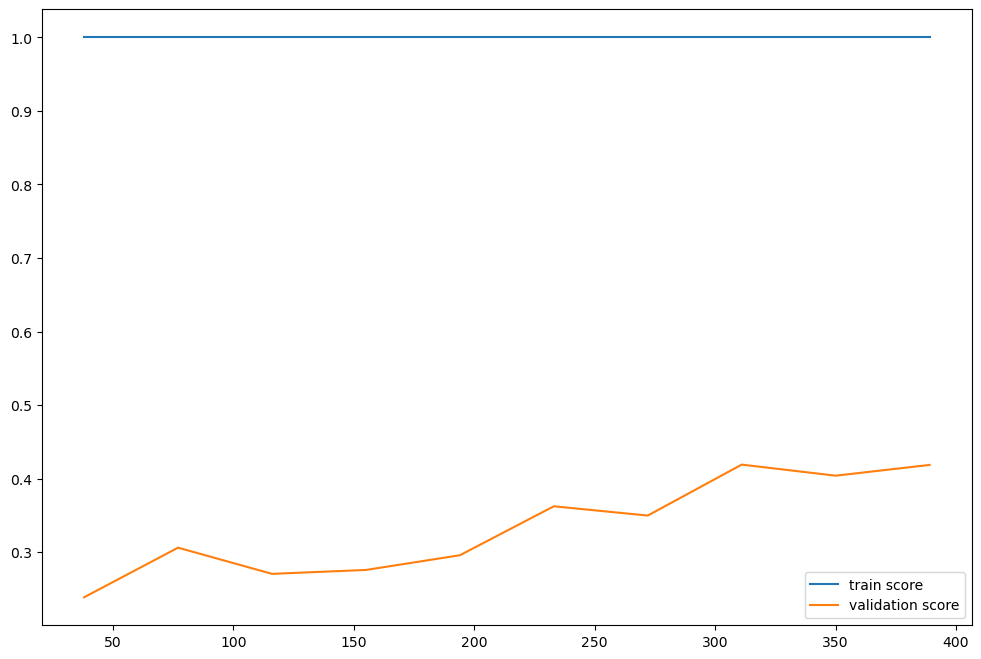

In [185]:
evaluation(model)

In [187]:
# 52 positif, 2 faux positif
# 10 faux négatif, 2 négatif

In [189]:
# Vérifier les features
model.feature_importances_

array([0.04418059, 0.04977197, 0.03985046, 0.112081  , 0.04038935,
       0.04999276, 0.05181301, 0.04494368, 0.21047229, 0.02778253,
       0.03854845, 0.07104398, 0.03950262, 0.08197711, 0.04390353,
       0.05374666])

<Axes: >

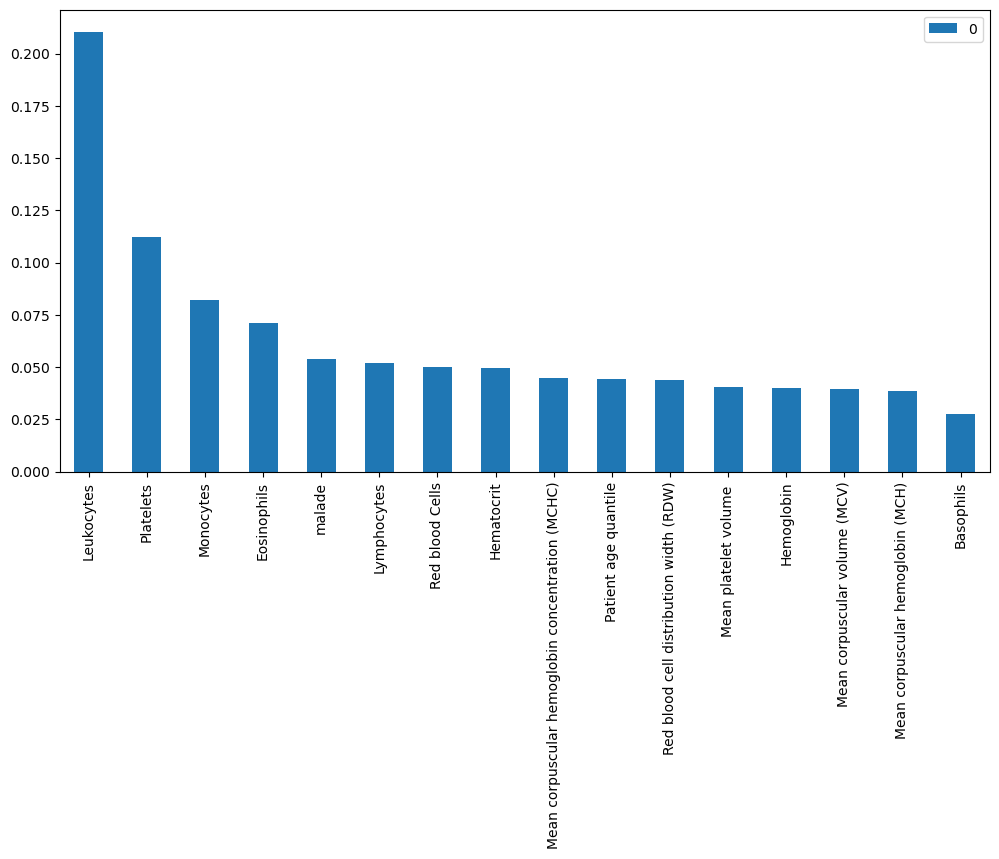

In [191]:
pd.DataFrame(model.feature_importances_, index= X_train.columns).sort_values(0, ascending= False).plot.bar(figsize= (12, 6))

In [193]:
# Key best selector basé sur un test ANOVA

In [195]:
model = make_pipeline(SelectKBest(f_classif, k=10), # modifier la valeur 'k' pour obtenir une f1-score +/- élevée
                      RandomForestClassifier(random_state= 0))

[[92  3]
 [11  5]]
              precision    recall  f1-score   support

           0       0.89      0.97      0.93        95
           1       0.62      0.31      0.42        16

    accuracy                           0.87       111
   macro avg       0.76      0.64      0.67       111
weighted avg       0.85      0.87      0.86       111



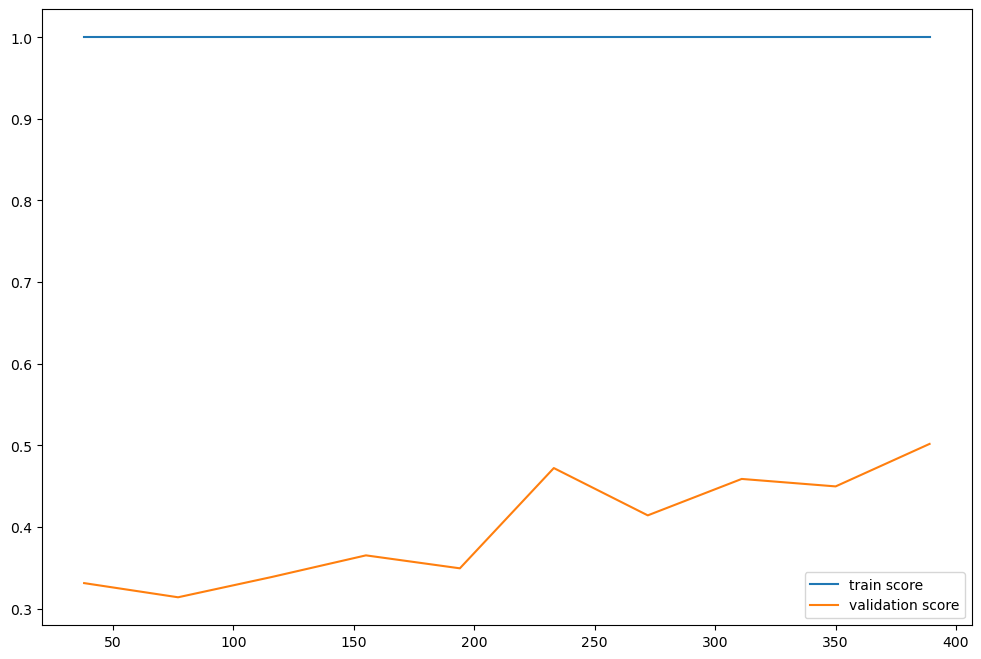

In [197]:
evaluation(model)

In [198]:
model = make_pipeline(PolynomialFeatures(2, include_bias=False),
                      SelectKBest(f_classif, k=10), # modifier la valeur 'k' pour obtenir une f1-score +/- élevée
                      RandomForestClassifier(random_state= 0))

In [201]:
def evaluation(model):
    model.fit(X_train, y_train)
    ypred = model.predict(X_test)
    
    print(confusion_matrix(y_test, ypred))
    print(classification_report(y_test, ypred))

    N, train_score, val_score = learning_curve(model, X_train, y_train, cv= 4, 
                                               scoring= 'f1', train_sizes= np.linspace(0.1, 1, 10))
    
    plt.figure(figsize=(12, 8))
    plt.plot(N, train_score.mean(axis= 1), label= 'train score')
    plt.plot(N, val_score.mean(axis= 1), label= 'validation score')
    plt.legend()
    plt.show()

[[91  4]
 [11  5]]
              precision    recall  f1-score   support

           0       0.89      0.96      0.92        95
           1       0.56      0.31      0.40        16

    accuracy                           0.86       111
   macro avg       0.72      0.64      0.66       111
weighted avg       0.84      0.86      0.85       111



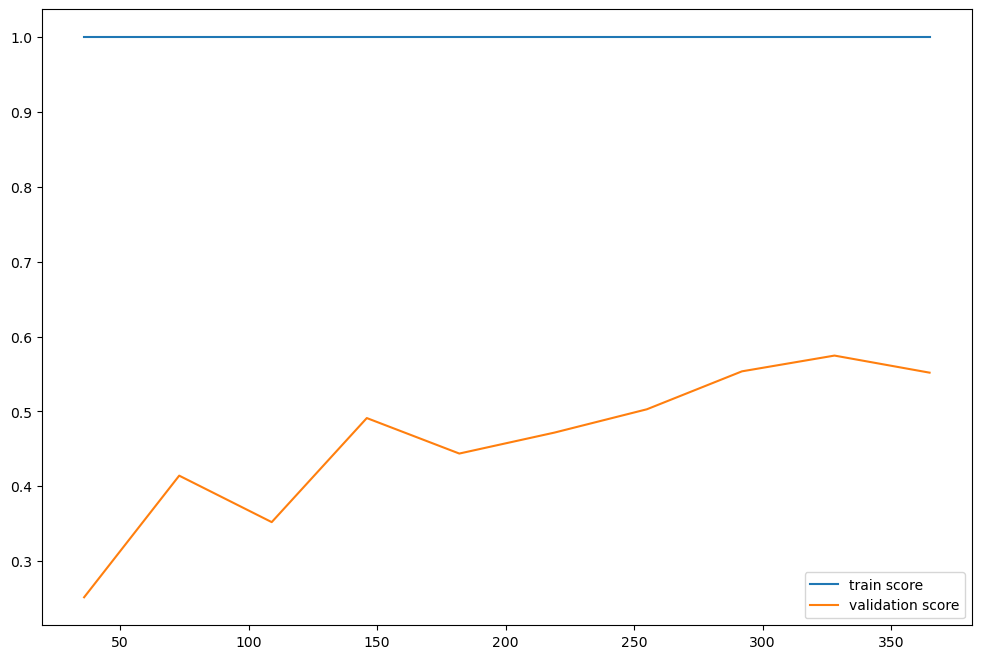

In [203]:
evaluation(model)

### Modélisation

In [207]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier # Pas besoin de normalisation
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

In [209]:
list_of_models = []

In [211]:
preprocessor = make_pipeline(PolynomialFeatures(2, include_bias=False), 
                             SelectKBest(f_classif, k=10))

In [213]:
# RandomForestClassifier et AdaBoostClassifier ont besoin de normalisation
RandomForest = make_pipeline(preprocessor, RandomForestClassifier(random_state= 0))
AdaBoost = make_pipeline(preprocessor, AdaBoostClassifier(random_state= 0))

# SVM et KNN ont besoin d'une normalisation
SVM = make_pipeline(preprocessor, StandardScaler(), SVC(random_state= 0))
KNN = make_pipeline(preprocessor, StandardScaler(), KNeighborsClassifier())

In [215]:
list_of_models = [RandomForest, AdaBoost, SVM, KNN]

In [221]:
dict_of_models = {'RandomForest': RandomForest,
                 'AdaBoost': AdaBoost, 
                 'SVM (Support Vector Machine)': SVM,
                 'KNN (KNeighbors)': KNN}

RandomForest
[[91  4]
 [11  5]]
              precision    recall  f1-score   support

           0       0.89      0.96      0.92        95
           1       0.56      0.31      0.40        16

    accuracy                           0.86       111
   macro avg       0.72      0.64      0.66       111
weighted avg       0.84      0.86      0.85       111



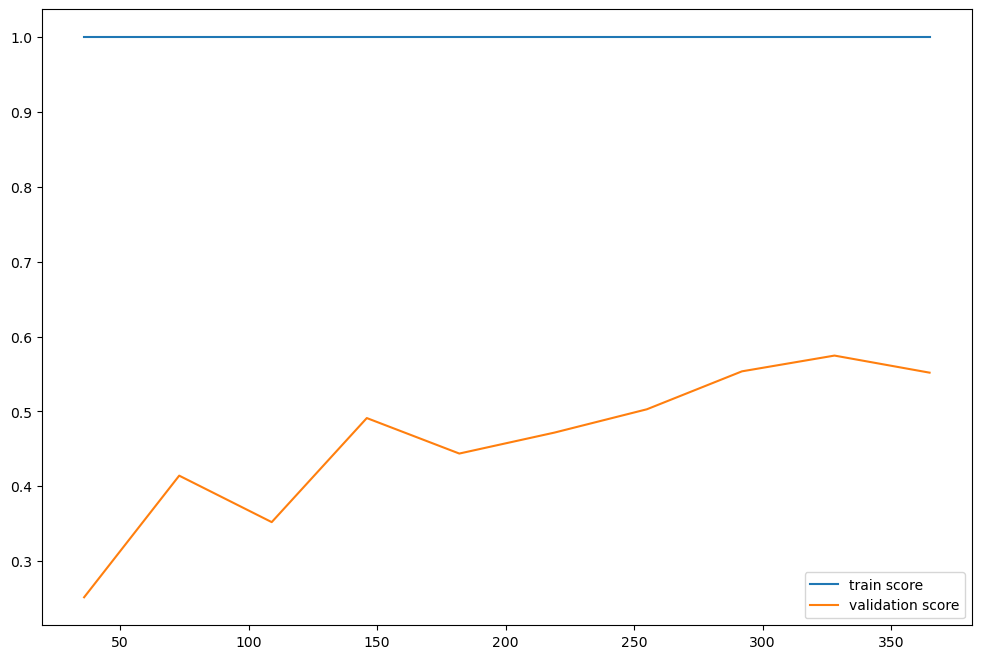

AdaBoost
[[91  4]
 [ 9  7]]
              precision    recall  f1-score   support

           0       0.91      0.96      0.93        95
           1       0.64      0.44      0.52        16

    accuracy                           0.88       111
   macro avg       0.77      0.70      0.73       111
weighted avg       0.87      0.88      0.87       111



/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/ana

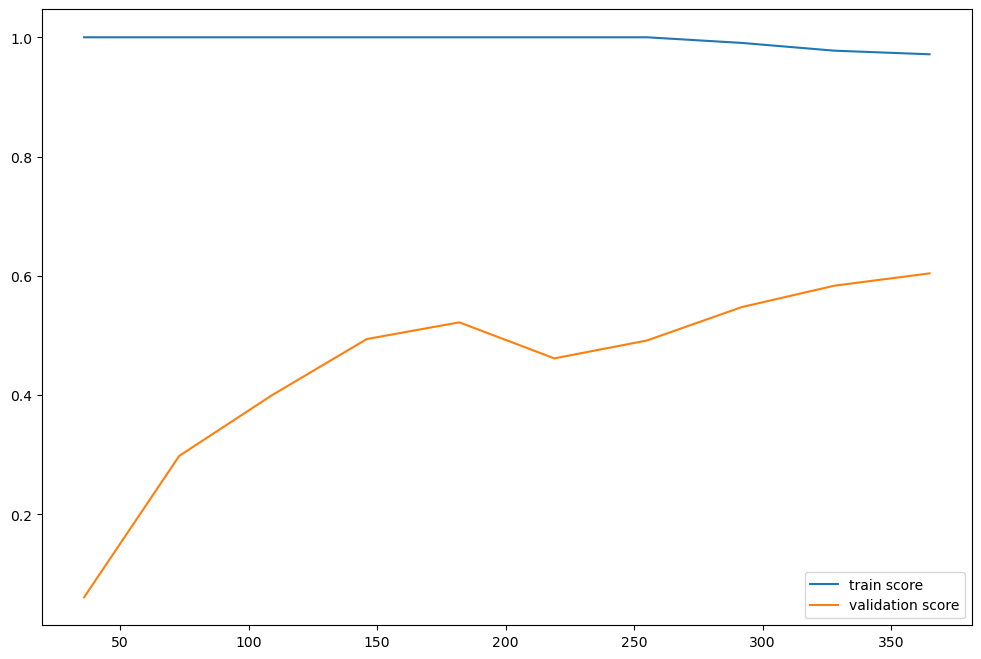

SVM
[[92  3]
 [10  6]]
              precision    recall  f1-score   support

           0       0.90      0.97      0.93        95
           1       0.67      0.38      0.48        16

    accuracy                           0.88       111
   macro avg       0.78      0.67      0.71       111
weighted avg       0.87      0.88      0.87       111



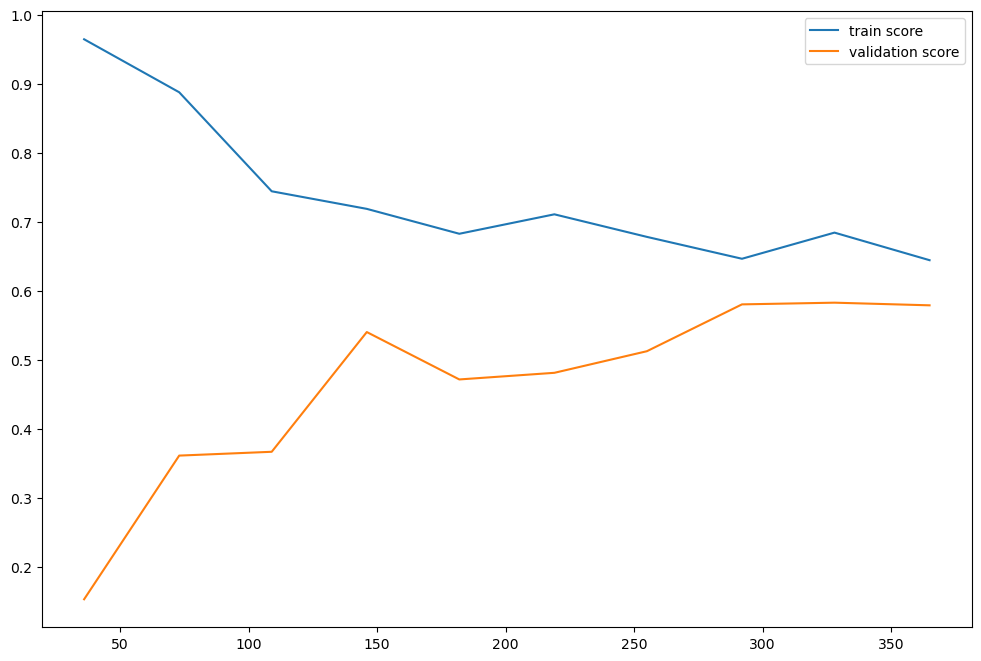

KNN
[[88  7]
 [ 8  8]]
              precision    recall  f1-score   support

           0       0.92      0.93      0.92        95
           1       0.53      0.50      0.52        16

    accuracy                           0.86       111
   macro avg       0.72      0.71      0.72       111
weighted avg       0.86      0.86      0.86       111



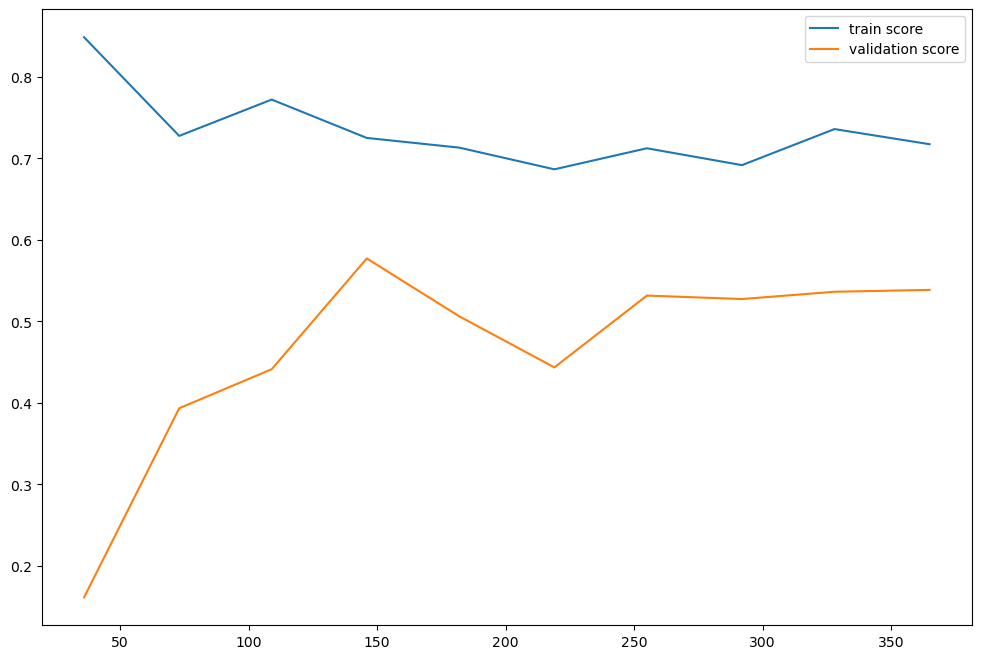

In [225]:
for name, model in dict_of_models.items():
    print(name)
    evaluation(model)

### Best Model & Evaluation

In [229]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [232]:
SVM

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('polynomialfeatures',
                                  PolynomialFeatures(include_bias=False)),
                                 ('selectkbest', SelectKBest())])),
                ('standardscaler', StandardScaler()),
                ('svc', SVC(random_state=0))])

In [248]:
hyper_params = {"svc__gamma":[1e-3, 1e-4, 0.0005],
               "svc__C":[1, 10, 100, 1000]}

In [250]:
grid = GridSearchCV(SVM, hyper_params, scoring= 'recall', cv= 4) # cv prend généralement comme valeur: 3, 4 ou 5.

grid.fit( X_train, y_train)

print(grid.best_params_)

y_pred = grid.predict( X_test)

print(classification_report(y_test, y_pred)) # Ne pas inverser 'y_test' et 'y_pred' !

{'svc__C': 1000, 'svc__gamma': 0.001}
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        95
           1       0.70      0.44      0.54        16

    accuracy                           0.89       111
   macro avg       0.81      0.70      0.74       111
weighted avg       0.88      0.89      0.88       111



In [252]:
# Il faudrait multiplier les hyper-paramètres pour trouver une version améliorée du modèle
# -> utiliser 'RandomizedSearchCV'

In [274]:
# Modifier la liste des hyper paramètres:
hyper_params = {"svc__gamma":[1e-3, 1e-4, 0.0005],
               "svc__C":[1, 10, 100, 1000],
               "pipeline__polynomialfeatures__degree": [2, 3, 4],
               "pipeline__selectkbest__k": range(4, 100)}

In [363]:
# Modifier la liste des hyper paramètres:
hyper_params = {"svc__gamma":[0.0004, 0.0005, 0.0006],
               "svc__C":[2800, 2600],
               "pipeline__polynomialfeatures__degree": [3],
               "pipeline__selectkbest__k": range(50, 90)}

grid = RandomizedSearchCV(SVM, hyper_params, scoring= 'recall', cv= 4, n_iter= 20)

grid.fit( X_train, y_train)

print(grid.best_params_)

y_pred = grid.predict( X_test)

print(classification_report(y_test, y_pred))

{'svc__gamma': 0.0005, 'svc__C': 2600, 'pipeline__selectkbest__k': 51, 'pipeline__polynomialfeatures__degree': 3}
              precision    recall  f1-score   support

           0       0.93      0.95      0.94        95
           1       0.64      0.56      0.60        16

    accuracy                           0.89       111
   macro avg       0.79      0.75      0.77       111
weighted avg       0.89      0.89      0.89       111



### Precision Recal Curve

In [392]:
from sklearn.metrics import precision_recall_curve, recall_score

- precision = VP  / FP # VP: vrai positif; FP: faux positif
- Rappel = VP / (VP + FN) # FN: Faux Négatif

In [372]:
precision, recall, threshold = precision_recall_curve(y_test, grid.best_estimator_.decision_function(X_test))

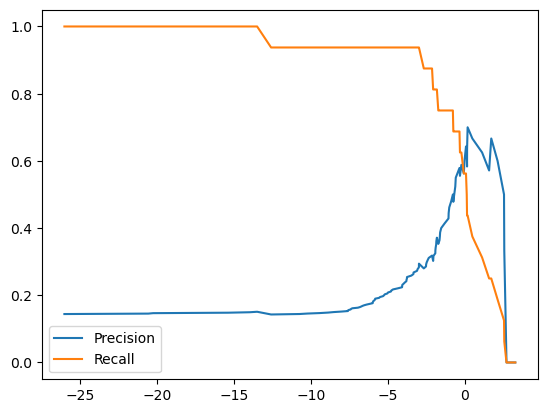

In [378]:
plt.plot(threshold, precision[:-1], label= 'Precision')
plt.plot(threshold, recall[:-1], label= 'Recall')
plt.legend()
plt.show()

In [380]:
def model_final(model, X, threshold= 0):
    return model.decision_function(X) > threshold

In [382]:
y_pred = model_final(grid.best_estimator_, X_test, threshold= -1)

In [388]:
f1_score(y_test, y_pred)

0.5853658536585366

In [ ]:
# RandomForest --> predict_proba

In [394]:
recall_score(y_test, y_pred)

0.75

In [398]:
df.duplicated().sum()

4785